In [109]:
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from mpl_toolkits.mplot3d import Axes3D 

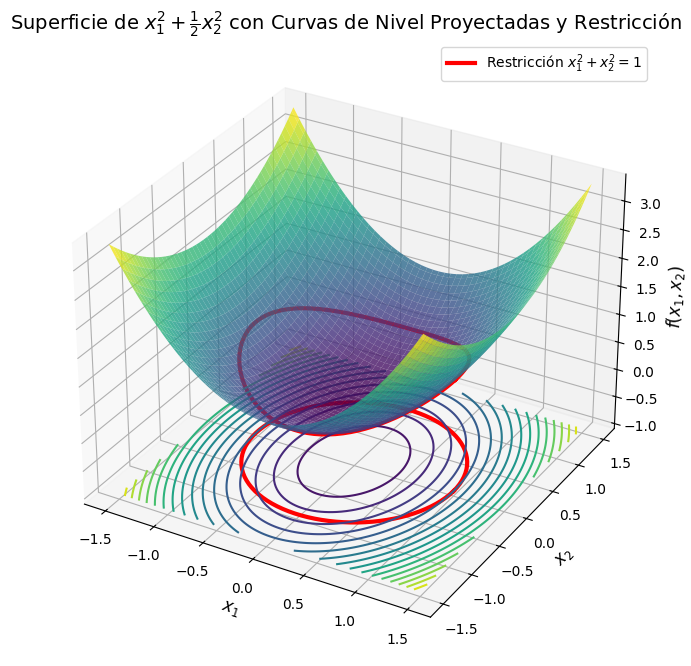

In [110]:
# Definimos las variables simbólicas
x1, x2 = sp.symbols('x1 x2')

# Definimos la función a optimizar
opti = x1**2 + 0.5*(x2**2)

# Convertimos la función sympy a una función numpy para evaluación eficiente
opti_np = sp.lambdify((x1, x2), opti, 'numpy')

# Creamos una cuadrícula de valores para x1 y x2
x1_vals = np.linspace(-1.5, 1.5, 100)
x2_vals = np.linspace(-1.5, 1.5, 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Evaluamos la función en cada punto de la cuadrícula
Z = opti_np(X1, X2)

# Generamos los puntos de la restricción
theta = np.linspace(0, 2 * np.pi, 100)
x1_restriccion = np.cos(theta)
x2_restriccion = np.sin(theta)
z_restriccion = opti_np(x1_restriccion, x2_restriccion)

# Creamos la gráfica en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficamos la superficie
ax.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.8, edgecolor='none')

# Graficamos la restricción
ax.plot(x1_restriccion, x2_restriccion, z_restriccion, color='r', linewidth=3, label='Restricción $x_1^2 + x_2^2 = 1$')

# Proyectamos las curvas de nivel
contour = ax.contour(X1, X2, Z, levels=20, cmap='viridis', offset=-1)

# Proyectamos la restricción en el plano de las curvas de nivel
ax.plot(x1_restriccion, x2_restriccion, -1 * np.ones_like(x1_restriccion), color='r', linewidth=3)

# Añadimos etiquetas y título
ax.set_title(r'Superficie de $x_1^2 + \frac{1}{2} x_2^2$ con Curvas de Nivel Proyectadas y Restricción', fontsize=14)
ax.set_xlabel(r'$x_1$', fontsize=12)
ax.set_ylabel(r'$x_2$', fontsize=12)
ax.set_zlabel(r'$f(x_1, x_2)$', fontsize=12)

# Añadimos la leyenda
ax.legend()

plt.show()



In [111]:

# Definición de variables simbólicas
x1, x2, mu = sp.symbols('x1 x2 mu')

# Función objetivo
f = x1**2 + 0.5 * x2**2

# Restricciones
g = [x1**2 + x2**2 - 1]

# Penalización basada en las restricciones
P = sum(h_j**2 for h_j in g)

# Función de penalidad
q = f + mu * P

# Gradientes y Hessiano de la función de penalidad q
variables = [x1, x2]
grad_q = [sp.diff(q, var) for var in variables]
hess_q = sp.Matrix([[sp.diff(q, var1, var2) for var1 in variables] for var2 in variables])

# Display de los gradientes y el hessiano para verificar
display(Latex("Gradientes:"))
for i, grad in enumerate(grad_q):
    display(Latex(f'$\\frac{{\\partial q}}{{\\partial x_{i+1}}} = {sp.latex(grad)}$'))

display(Latex("Hessiano:"))
for i in range(len(variables)):
    for j in range(len(variables)):
        display(Latex(f'$\\frac{{\\partial^2 q}}{{\\partial x_{i+1} \\partial x_{j+1}}} = {sp.latex(hess_q[i, j])}$'))

display(Latex(f'$H={sp.latex(hess_q)}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [112]:
def armijo(x0, opti, grad_q, mu_val):
    b, s, o, k1, m = 0.5, 1, 0.1, 1, 0

    while True:
        # Hallamos el valor de lambda
        lmb = s * (b ** m)
        # Hallamos f(x0)
        f = float(opti.subs({x1: x0[0], x2: x0[1], mu: mu_val}).evalf())
        # Hallamos el valor de la gradiente
        grad = sp.Matrix([grad_q[i].subs({x1: x0[0], x2: x0[1], mu: mu_val}) for i in range(len(variables))]).evalf()
        # Hallamos el valor de f(x0 - lmb * grad)
        x_new = [x0[0] - lmb * grad[0], x0[1] - lmb * grad[1]]
        f_k = float(opti.subs({x1: x_new[0], x2: x_new[1], mu: mu_val}).evalf())
        mod = float((grad[0] ** 2 + grad[1] ** 2).evalf())

        # Condición de parada
        if f_k <= float(f - o * lmb * mod):
            break
        else:
            m += 1
            k1 += 1

    return k1, lmb

In [113]:
def busqueda_exacta(x0, d_k, opti, mu_val):
    alpha = sp.symbols('alpha')
    x_new = [x0[0] + alpha * d_k[0], x0[1] + alpha * d_k[1]]
    func_new = opti.subs({x1: x_new[0], x2: x_new[1], mu: mu_val})
    dfunc_new = sp.diff(func_new, alpha)

    # Encontrar la solución de alpha que minimiza la función
    alpha_opt = sp.solve(dfunc_new, alpha)
    alpha_opt = [sol.evalf() for sol in alpha_opt if sol.is_real and sol > 0]

    if alpha_opt:
        return min(alpha_opt)
    else:
        return 1  # Valor de fallback en caso de que no se encuentre un valor óptimo


In [114]:
def gradiente_armijo(mu_val, x0, tol, max_iter):
    x = sp.Matrix(x0)
    data = []

    for k in range(max_iter):
        # Obtener la gradiente de la función de penalidad
        grad = sp.Matrix([grad_q[i].subs({x1: x[0], x2: x[1], mu: mu_val}) for i in range(len(variables))]).evalf()

        # Obtener la norma del gradiente
        Normadf = float(grad.norm().evalf())

        # Condición para finalizar el programa
        if Normadf < tol:
            break

        # Obtener el número de iteraciones internas y el valor de lambda usando Armijo
        iter, lmb = armijo([x[0], x[1]], q, grad_q, mu_val)

        # Actualizar el valor de x
        x_new = (x - lmb * grad).evalf()

        # Hallar el valor de la función en x
        fun = float(q.subs({x1: x_new[0], x2: x_new[1], mu: mu_val}).evalf())

        # Error
        mod = float(x_new.norm().evalf())

        # Introducir el número de iteraciones, iteraciones internas, lambda, x0 y fun(x0)
        data.append([k, iter, x_new, fun, mod])

        # Mostrar el paso actual
        #display(Latex(f'Iteración {k}: $x = ({sp.latex(x_new[0])}, {sp.latex(x_new[1])})$, $\\nabla q = {sp.latex(grad)}$, $||\\nabla q|| = {sp.latex(Normadf)}$'))

        x = x_new

    return x, data


In [115]:
def gradiente_busqueda_exacta(mu_val, x0, tol, max_iter):
    x = sp.Matrix(x0)
    data = []

    for k in range(max_iter):
        # Obtener la gradiente de la función de penalidad
        grad = sp.Matrix([grad_q[i].subs({x1: x[0], x2: x[1], mu: mu_val}) for i in range(len(variables))]).evalf()

        # Obtener la norma del gradiente
        Normadf = float(grad.norm().evalf())

        # Condición para finalizar el programa
        if Normadf < tol:
            print(f"Parando por criterio: ||grad|| < tol en la iteración {k}")
            break

        # Calcular el valor de alpha usando Búsqueda Exacta
        lmb = busqueda_exacta([x[0], x[1]], -grad, q, mu_val)
        lmb = float(lmb)  # Asegurar que alpha sea un número flotante
        print(f"Iteración {k}, alpha: {lmb}")

        # Actualizar el valor de x
        x_new = (x - lmb * grad).evalf()

        # Hallar el valor de la función en x
        fun = float(q.subs({x1: x_new[0], x2: x_new[1], mu: mu_val}).evalf())

        # Error
        mod = float(x_new.norm().evalf())

        # Introducir el número de iteraciones, iteraciones internas, lambda, x0 y fun(x0)
        data.append([k, 1, x_new, fun, mod])

        # Mostrar el paso actual
        print(f"Iteración {k}, x: {x_new}, grad: {grad}, Normadf: {Normadf}, f(x): {fun}, ||x||: {mod}")

        x = x_new

    return x, data


In [116]:
def optimize_newton_puro_armijo(mu_val, x0, tol, max_iter):
    x = sp.Matrix(x0)
    data = []

    for k in range(max_iter):
        # Calcular el gradiente y el Hessiano de la función de penalidad
        grad = sp.Matrix([grad_q[i].subs({x1: x[0], x2: x[1], mu: mu_val}) for i in range(len(variables))]).evalf()
        hess = sp.Matrix([[hess_q[i, j].subs({x1: x[0], x2: x[1], mu: mu_val}) for j in range(len(variables))] for i in range(len(variables))]).evalf()

        # Calcular la dirección de Newton
        d_k = -hess.inv() * grad

        # Obtener el valor de lambda usando Armijo
        lmb = armijo_newton([x[0], x[1]], d_k, q, grad_q, mu_val)
        print(f"Iteration {k}, alpha: {lmb}")

        # Actualizar el valor de x
        x_new = (x + lmb * d_k).evalf()

        # Hallar el valor de la función en x
        fun = float(q.subs({x1: x_new[0], x2: x_new[1], mu: mu_val}).evalf())

        # Error
        mod = float(x_new.norm().evalf())

        # Introducir el número de iteraciones, iteraciones internas, lambda, x0 y fun(x0)
        data.append([k, 1, x_new, fun, mod])

        # Mostrar el paso actual
        print(f"Iteration {k}, x: {x_new}, grad: {grad}, Normadf: {grad.norm()}, f(x): {fun}, ||x||: {mod}")

        # Condición de parada
        if grad.norm() < tol:
            print(f"Parando por criterio: norm < epsilon at iteration {k}")
            break

        x = x_new

    return x, data

In [117]:
def armijo_newton(x0, d_k, opti, grad_q, mu_val):
    b, s, o, k1, m = 0.5, 1, 0.1, 1, 0

    while True:
        # Hallamos el valor de lambda
        lmb = s * (b ** m)
        # Hallamos f(x0)
        f = float(opti.subs({x1: x0[0], x2: x0[1], mu: mu_val}).evalf())
        # Hallamos el valor de f(x0 + lmb * d_k)
        x_new = [x0[0] + lmb * d_k[0], x0[1] + lmb * d_k[1]]
        f_k = float(opti.subs({x1: x_new[0], x2: x_new[1], mu: mu_val}).evalf())
        mod = float((sp.Matrix(d_k).norm() ** 2).evalf())

        # Condición de parada
        if f_k <= float(f + o * lmb * mod):
            break
        else:
            m += 1
            k1 += 1

    return lmb

def optimize_newton_puro_armijo(mu_val, x0, tol, max_iter):
    x = sp.Matrix(x0)
    data = []

    for k in range(max_iter):
        # Calcular el gradiente y el Hessiano de la función de penalidad
        grad = sp.Matrix([grad_q[i].subs({x1: x[0], x2: x[1], mu: mu_val}) for i in range(len(variables))]).evalf()
        hess = sp.Matrix([[hess_q[i, j].subs({x1: x[0], x2: x[1], mu: mu_val}) for j in range(len(variables))] for i in range(len(variables))]).evalf()

        # Calcular la dirección de Newton
        d_k = -hess.inv() * grad

        # Obtener el valor de lambda usando Armijo
        lmb = armijo_newton([x[0], x[1]], d_k, q, grad_q, mu_val)
        print(f"Iteration {k}, alpha: {lmb}")

        # Actualizar el valor de x
        x_new = (x + lmb * d_k).evalf()

        # Hallar el valor de la función en x
        fun = float(q.subs({x1: x_new[0], x2: x_new[1], mu: mu_val}).evalf())

        # Error
        mod = float(x_new.norm().evalf())

        # Introducir el número de iteraciones, iteraciones internas, lambda, x0 y fun(x0)
        data.append([k, 1, x_new, fun, mod])

        # Mostrar el paso actual
        print(f"Iteration {k}, x: {x_new}, grad: {grad}, Normadf: {grad.norm()}, f(x): {fun}, ||x||: {mod}")

        # Condición de parada
        if grad.norm() < tol:
            print(f"Parando por criterio: norm < epsilon at iteration {k}")
            break

        x = x_new

    return x, data


In [118]:
def optimize_newton_puro_exacta(mu_val, x0, tol, max_iter):
    x = sp.Matrix(x0)
    data = []

    for k in range(max_iter):
        # Calcular gradiente y hessiano
        grad = sp.Matrix([grad_q[i].subs({x1: x[0], x2: x[1], mu: mu_val}) for i in range(len(variables))]).evalf()
        hess = sp.Matrix([[hess_q[i, j].subs({x1: x[0], x2: x[1], mu: mu_val}) for j in range(len(variables))] for i in range(len(variables))]).evalf()

        # Norma del gradiente
        Normadf = float(grad.norm())

        if Normadf < tol:
            break

        # Direccion de descenso
        d_k = -hess.inv() * grad

        # Calcular el valor de lambda usando Búsqueda Exacta
        lmb = busqueda_exacta([x[0], x[1]], d_k, q, mu_val)

        # Actualizar x
        x_new = (x + lmb * d_k).evalf()

        # Calcular f(x) y el error
        fun = float(q.subs({x1: x_new[0], x2: x_new[1], mu: mu_val}).evalf())
        mod = float(x_new.norm().evalf())

        data.append([k, 1, x_new.tolist(), fun, mod])

        # Mostrar el paso actual
        #display(Latex(f'Iteración {k}: $x = ({x_new[0]}, {x_new[1]})$, $\\nabla q = {grad}$, $||\\nabla q|| = {Normadf}$'))

        x = x_new

    return x, data


In [119]:
def conjugate_gradient_armijo(mu_val, x0, tol=1e-6, max_iter=1000, alpha=1, beta=0.5, sigma=1e-4):
    x = sp.Matrix(x0)
    grad = sp.Matrix([grad_q[i].subs({x1: x[0], x2: x[1], mu: mu_val}) for i in range(len(variables))]).evalf()
    d = -grad
    iter_count = 0
    total_internal_iter_count = 0
    data = []

    for _ in range(max_iter):
        if grad.norm() < tol:
            break

        t = alpha
        internal_iter_count = 0
        while float(q.subs({x1: x[0] + t * d[0], x2: x[1] + t * d[1], mu: mu_val}).evalf()) > float(q.subs({x1: x[0], x2: x[1], mu: mu_val}).evalf()) + sigma * t * float((grad.T * d)[0]):
            t *= beta
            internal_iter_count += 1

        x_new = (x + t * d).evalf()
        grad_new = sp.Matrix([grad_q[i].subs({x1: x_new[0], x2: x_new[1], mu: mu_val}) for i in range(len(variables))]).evalf()
        beta_cg = (grad_new.T * grad_new)[0] / (grad.T * grad)[0]
        d = -grad_new + beta_cg * d
        x = x_new
        grad = grad_new
        iter_count += 1
        total_internal_iter_count += internal_iter_count
        data.append([iter_count, internal_iter_count, x.tolist(), float(q.subs({x1: x[0], x2: x[1], mu: mu_val}).evalf()), float(x.norm().evalf())])

    return x, iter_count, total_internal_iter_count, data


In [120]:
def conjugate_gradient_exact(mu_val, x0, tol=1e-6, max_iter=1000):
    x = sp.Matrix(x0)
    grad = sp.Matrix([grad_q[i].subs({x1: x[0], x2: x[1], mu: mu_val}) for i in range(len(variables))]).evalf()
    d = -grad
    iter_count = 0
    data = []

    for _ in range(max_iter):
        if grad.norm() < tol:
            print(f"Converged: grad.norm() < tol at iteration {iter_count}")
            break

        # Calcular el valor de alpha usando Búsqueda Exacta
        alpha = busqueda_exacta(x, d, q, mu_val)
        alpha = float(alpha)  # Asegurar que alpha sea un número flotante
        print(f"Iteration {iter_count}, alpha: {alpha}")

        x_new = (x + alpha * d).evalf()
        grad_new = sp.Matrix([grad_q[i].subs({x1: x_new[0], x2: x_new[1], mu: mu_val}) for i in range(len(variables))]).evalf()
        
        beta_num = (grad_new.T * grad_new)[0]
        beta_den = (grad.T * grad)[0]
        
        if beta_den == 0:
            beta = 0
        else:
            beta = beta_num / beta_den

        # Limitar el valor de beta para evitar pasos excesivamente grandes
        if beta > 1:
            beta = 1

        d = -grad_new + beta * d
        x = x_new
        grad = grad_new
        iter_count += 1
        data.append([iter_count, 1, x.tolist(), float(q.subs({x1: x[0], x2: x[1], mu: mu_val}).evalf()), float(x.norm().evalf())])
        
        print(f"Iteration {iter_count}, x: {x}, grad: {grad}, beta: {beta}")

    return x, iter_count, data

In [121]:
# Parámetros iniciales
x0 = [3, 0.5]  # Punto inicial factible resulta (0,-1)
x0 = [0.5, 1]  # Punto inicial factible resulta (0, 1)
#x0 = [1, 0]  # Punto inicial factible resulta (1, 0)
epsilon = 1e-3
max_iter = 100
tol = 1e-3

# Método de penalidad exterior
mu_values = []
solutions = []
all_data = []

for k in range(1, max_iter + 1):
    mu_val = k

    #x_new, data =  gradiente_armijo(mu_val, x0, tol, max_iter) #Gozu

    #x_new, data =  gradiente_busqueda_exacta(mu_val, x0, tol, max_iter)

    x_new, data = optimize_newton_puro_armijo(mu_val, x0, tol, max_iter)#Gozu

    #x_new, data = optimize_newton_puro_exacta(mu_val, x0, tol, max_iter)#Gozu
    
    #x_new, iter_count, total_internal_iter_count, data = conjugate_gradient_armijo(mu_val, x0, tol, max_iter)#gozu

    #x_new, iter_count, data = conjugate_gradient_exact(mu_val, x0, tol, max_iter)
    
    # Verificar criterio de parada
    if (sp.Matrix(x_new) - sp.Matrix(x0)).norm().evalf() < epsilon:
        print(f"Parando por criterio: norm < epsilon at iteration {k}")
        break
    
    x0 = x_new
    mu_values.append(mu_val)
    solutions.append(x0)
    all_data.extend(data)

# Mostrar los resultados
df = pd.DataFrame(all_data, columns=['Iteración', 'Iteraciones Internas', 'x', 'f(x)', '|| x - x||'])
df = df.sort_values(by='Iteración').reset_index(drop=True)
display(df)

for mu_val, sol in zip(mu_values, solutions):
    display(Latex(f'$\\mu = {mu_val}, \\; x^* = ({sol[0]}, {sol[1]})$'))


Iteration 0, alpha: 1.0
Iteration 0, x: Matrix([[0.294117647058824], [0.882352941176471]]), grad: Matrix([[1.50000000000000], [2.00000000000000]]), Normadf: 2.50000000000000, f(x): 0.4939895355659056, ||x||: 0.9300816647554057
Iteration 1, alpha: 1.0
Iteration 1, x: Matrix([[0.0928800655775164], [0.884106488880720]]), grad: Matrix([[0.429472827193161], [0.406065540403012]]), Normadf: 0.591046641476015, f(x): 0.44343510594757857, ||x||: 0.8889718725936598
Iteration 2, alpha: 1.0
Iteration 2, x: Matrix([[0.0126819002151382], [0.870117136461522]]), grad: Matrix([[0.107841554443393], [0.142415375219544]]), Normadf: 0.178639133349025, f(x): 0.4376331906069779, ||x||: 0.8702095504860112
Iteration 3, alpha: 1.0
Iteration 3, x: Matrix([[0.000356476275660364], [0.866141322426274]]), grad: Matrix([[0.0130504190771375], [0.0252844267416783]]), Normadf: 0.0284537462163458, f(x): 0.4375001039055052, ||x||: 0.8661413957834304
Iteration 4, alpha: 1.0
Iteration 4, x: Matrix([[2.86220936646531e-7], [0.

,Iteración,Iteraciones Internas,x,f(x),|| x - x||
0,0,1,"[0.294117647058824, 0.882352941176471]",0.493990,0.930082
1,0,1,"[-0.120591676344778, 0.905485180022180]",0.479310,0.913480
2,0,1,"[4.73643038083577e-9, 0.968431981944233]",0.484376,0.968432
3,0,1,"[-5.17710358219832e-7, 0.958229325031164]",0.479174,0.958229
4,0,1,"[2.53173042180765e-19, 0.984258784507132]",0.492188,0.984259
5,0,1,"[-1.52664105125272e-18, 0.981994683290675]",0.491071,0.981995
6,0,1,"[5.75720748589608e-15, 0.978973176397526]",0.489583,0.978973
7,0,1,"[-9.11335751473127e-12, 0.974744129669339]",0.487500,0.974744
8,0,1,"[-4.98648591193365e-22, 0.988573055468043]",0.494318,0.988573
9,0,1,"[-3.60492213955083e-20, 0.986017999679983]",0.493056,0.986018


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [122]:
# Parámetros iniciales
x0 = [0.5, 1.0]  # Punto inicial factible
epsilon = 1e-3
max_iter = 100
tol = 1e-3

# Método de penalidad exterior
mu_values = []
solutions = []
all_data = []

for k in range(1, max_iter + 1):
    mu_val = k

    x_new, data = gradiente_armijo(mu_val, x0, tol, max_iter)
    
    # Verificar criterio de parada
    if (sp.Matrix(x_new) - sp.Matrix(x0)).norm() < epsilon:
        print(f"Parando por criterio: norm < epsilon at iteration {k}")
        break
    
    x0 = x_new
    mu_values.append(mu_val)
    solutions.append(x0)
    all_data.extend(data)

# Mostrar los resultados
df2 = pd.DataFrame(all_data, columns=['Iteración', 'Iteraciones Internas', 'x', 'f(x)', '|| x - x||'])
df2 = df2.sort_values(by='Iteración').reset_index(drop=True)
display(df2)

for mu_val, sol in zip(mu_values, solutions):
    display(Latex(f'$\\mu = {mu_val}, \\; x^* = ({sol[0]}, {sol[1]})$'))


Parando por criterio: norm < epsilon at iteration 12


,Iteración,Iteraciones Internas,x,f(x),|| x - x||
0,0,4,"[0.312500000000000, 0.750000000000000]",0.494400,0.812500
1,0,4,"[0.000295836610739517, 0.974309936369953]",0.479785,0.974310
2,0,6,"[2.98915252439346e-5, 0.967402247452707]",0.484386,0.967402
3,0,6,"[1.95053333208471e-5, 0.984035008534099]",0.491186,0.984035
4,0,6,"[2.42763656001827e-5, 0.980774332543055]",0.489660,0.980774
...,...,...,...,...,...
78,14,4,"[4.67843524347744e-5, 0.935349597843497]",0.468750,0.935350
79,15,3,"[0.00105252439873444, 0.866192228186795]",0.437501,0.866193
80,16,2,"[0.000525651558436453, 0.865689691210854]",0.437500,0.865690
81,17,3,"[0.000394544115602754, 0.866192728099922]",0.437500,0.866193


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [123]:
# Parámetros iniciales
x0 = [3, 0.5]  # Punto inicial factible resulta (0,-1)
x0 = [0.5, 1]  # Punto inicial factible resulta (0, 1)
#x0 = [1, 0]  # Punto inicial factible resulta (1, 0)
epsilon = 1e-3
max_iter = 100
tol = 1e-3

# Método de penalidad exterior
mu_values = []
solutions = []
all_data = []

for k in range(1, max_iter + 1):
    mu_val = k

    x_new, data = optimize_newton_puro_exacta(mu_val, x0, tol, max_iter)#Gozu
    
    # Verificar criterio de parada
    if (sp.Matrix(x_new) - sp.Matrix(x0)).norm().evalf() < epsilon:
        print(f"Parando por criterio: norm < epsilon at iteration {k}")
        break
    
    x0 = x_new
    mu_values.append(mu_val)
    solutions.append(x0)
    all_data.extend(data)

# Mostrar los resultados
df = pd.DataFrame(all_data, columns=['Iteración', 'Iteraciones Internas', 'x', 'f(x)', '|| x - x||'])
df = df.sort_values(by='Iteración').reset_index(drop=True)
display(df)

for mu_val, sol in zip(mu_values, solutions):
    display(Latex(f'$\\mu = {mu_val}, \\; x^* = ({sol[0]}, {sol[1]})$'))


Parando por criterio: norm < epsilon at iteration 12


,Iteración,Iteraciones Internas,x,f(x),|| x - x||
0,0,1,"[[0.167113208798350], [0.809778976456200]]",0.455863,0.826843
1,0,1,"[[0.116123387049260], [0.911524509632000]]",0.477370,0.918891
2,0,1,"[[-7.36004714721007e-5], [0.958230587040773]]",0.479174,0.958231
3,0,1,"[[3.60480594711647e-17], [0.984258784507132]]",0.492188,0.984259
4,0,1,"[[8.19740348545668e-13], [0.978973176397526]]",0.489583,0.978973
5,0,1,"[[-2.17370881720445e-16], [0.981994683290675]]",0.491071,0.981995
6,0,1,"[[-1.29760598069622e-9], [0.974744129669337]]",0.487500,0.974744
7,0,1,"[[6.74397668746738e-7], [0.968431981740709]]",0.484376,0.968432
8,0,1,"[[6.40111493506246e-19], [0.987423882581306]]",0.493750,0.987424
9,0,1,"[[-7.10001108953704e-20], [0.988573055468043]]",0.494318,0.988573


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [124]:
# Parámetros iniciales
x0 = [3, 0.5]  # Punto inicial factible resulta (0,-1)
x0 = [0.5, 1]  # Punto inicial factible resulta (0, 1)
#x0 = [1, 0]  # Punto inicial factible resulta (1, 0)
epsilon = 1e-3
max_iter = 100
tol = 1e-3

# Método de penalidad exterior
mu_values = []
solutions = []
all_data = []

for k in range(1, max_iter + 1):
    mu_val = k
    
    x_new, iter_count, total_internal_iter_count, data = conjugate_gradient_armijo(mu_val, x0, tol, max_iter)#gozu
    
    # Verificar criterio de parada
    if (sp.Matrix(x_new) - sp.Matrix(x0)).norm().evalf() < epsilon:
        print(f"Parando por criterio: norm < epsilon at iteration {k}")
        break
    
    x0 = x_new
    mu_values.append(mu_val)
    solutions.append(x0)
    all_data.extend(data)

# Mostrar los resultados
df = pd.DataFrame(all_data, columns=['Iteración', 'Iteraciones Internas', 'x', 'f(x)', '|| x - x||'])
df = df.sort_values(by='Iteración').reset_index(drop=True)
display(df)

for mu_val, sol in zip(mu_values, solutions):
    display(Latex(f'$\\mu = {mu_val}, \\; x^* = ({sol[0]}, {sol[1]})$'))


Parando por criterio: norm < epsilon at iteration 12


,Iteración,Iteraciones Internas,x,f(x),|| x - x||
0,1,2,"[[0.125000000000000], [0.500000000000000]]",0.679932,0.515388
1,1,3,"[[-0.000162890588481179], [0.974278907763815]]",0.479767,0.974279
2,1,4,"[[-1.38038912895178e-5], [0.977336635100262]]",0.485626,0.977337
3,1,4,"[[-2.54834915709237e-5], [0.964651041004511]]",0.479745,0.964651
4,1,5,"[[8.59958935093016e-7], [0.975811857226389]]",0.487524,0.975812
...,...,...,...,...,...
64,8,3,"[[-2.63048627709007e-5], [0.935396579131877]]",0.468750,0.935397
65,9,5,"[[-4.20926605629967e-8], [0.984282737217999]]",0.492188,0.984283
66,9,3,"[[1.01104480788093e-6], [0.968301295306136]]",0.484375,0.968301
67,10,4,"[[8.80587304570154e-7], [0.968236082649149]]",0.484375,0.968236


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [125]:
# Definición de variables simbólicas
x1, x2, mu = sp.symbols('x1 x2 mu')

# Función objetivo para el segundo ejercicio
f = (x1 - 5)**2 + (x2 - 5)**2

# Restricciones
g = [x1**2 - x2 - 6, x1 + 3*x2 - 12, -x1, -x2]  # Usamos ecuaciones de la forma g(x) <= 0

# Penalización basada en las restricciones
P = sum(sp.Piecewise((0, h_j <= 0), (h_j**2, h_j > 0)) for h_j in g)

# Función de penalidad
q = f + mu * P

# Gradientes y Hessiano de la función de penalidad q
variables = [x1, x2]
grad_q = [sp.diff(q, var) for var in variables]
hess_q = sp.Matrix([[sp.diff(q, var1, var2) for var1 in variables] for var2 in variables])

# Display de los gradientes y el hessiano para verificar
display(Latex("Gradientes:"))
for i, grad in enumerate(grad_q):
    display(Latex(f'$\\frac{{\\partial q}}{{\\partial x_{i+1}}} = {sp.latex(grad)}$'))

display(Latex("Hessiano:"))
for i in range(len(variables)):
    for j in range(len(variables)):
        display(Latex(f'$\\frac{{\\partial^2 q}}{{\\partial x_{i+1} \\partial x_{j+1}}} = {sp.latex(hess_q[i, j])}$'))

display(Latex(f'$H = {sp.latex(hess_q)}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [126]:
# Parámetros iniciales
x0 = [0.5, 1.0]  # Punto inicial factible
epsilon = 1e-3
max_iter = 100
tol = 1e-3

# Método de penalidad exterior
mu_values = []
solutions = []
all_data = []

for k in range(1, max_iter + 1):
    mu_val = k

    #x_new, data =  gradiente_armijo(mu_val, x0, tol, max_iter) #Gozu

    #x_new, data =  gradiente_busqueda_exacta(mu_val, x0, tol, max_iter)

    #x_new, data = optimize_newton_puro_armijo(mu_val, x0, tol, max_iter) #gozu

    #x_new, data = optimize_newton_puro_exacta(mu_val, x0, tol, max_iter)
    
    x_new, iter_count, total_internal_iter_count, data = conjugate_gradient_armijo(mu_val, x0, tol, max_iter) #Gozu

    #x_new, iter_count, data = conjugate_gradient_exact(mu_val, x0, tol, max_iter)
    
    # Verificar criterio de parada
    if (sp.Matrix(x_new) - sp.Matrix(x0)).norm() < epsilon:
        print(f"Parando por criterio: norm < epsilon at iteration {k}")
        break
    
    x0 = x_new
    mu_values.append(mu_val)
    solutions.append(x0)
    all_data.extend(data)

# Mostrar los resultados
df2 = pd.DataFrame(all_data, columns=['Iteración', 'Iteraciones Internas', 'x', 'f(x)', '|| x - x||'])
df2 = df.sort_values(by='Iteración').reset_index(drop=True)
display(df2)

for mu_val, sol in zip(mu_values, solutions):
    display(Latex(f'$\\mu = {mu_val}, \\; x^* = ({sol[0]}, {sol[1]})$'))


Parando por criterio: norm < epsilon at iteration 16


,Iteración,Iteraciones Internas,x,f(x),|| x - x||
0,1,2,"[[0.125000000000000], [0.500000000000000]]",0.679932,0.515388
1,1,3,"[[-0.000162890588481179], [0.974278907763815]]",0.479767,0.974279
2,1,4,"[[-1.38038912895178e-5], [0.977336635100262]]",0.485626,0.977337
3,1,4,"[[-2.54834915709237e-5], [0.964651041004511]]",0.479745,0.964651
4,1,5,"[[8.59958935093016e-7], [0.975811857226389]]",0.487524,0.975812
...,...,...,...,...,...
64,8,3,"[[-2.63048627709007e-5], [0.935396579131877]]",0.468750,0.935397
65,9,5,"[[-4.20926605629967e-8], [0.984282737217999]]",0.492188,0.984283
66,9,3,"[[1.01104480788093e-6], [0.968301295306136]]",0.484375,0.968301
67,10,4,"[[8.80587304570154e-7], [0.968236082649149]]",0.484375,0.968236


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [127]:
# Parámetros iniciales
x0 = [0.5, 1.0]  # Punto inicial factible
epsilon = 1e-3
max_iter = 100
tol = 1e-3

# Método de penalidad exterior
mu_values = []
solutions = []
all_data = []

for k in range(1, max_iter + 1):
    mu_val = k

    x_new, data =  gradiente_armijo(mu_val, x0, tol, max_iter) #Gozu
    
    # Verificar criterio de parada
    if (sp.Matrix(x_new) - sp.Matrix(x0)).norm() < epsilon:
        print(f"Parando por criterio: norm < epsilon at iteration {k}")
        break
    
    x0 = x_new
    mu_values.append(mu_val)
    solutions.append(x0)
    all_data.extend(data)

# Mostrar los resultados
df2 = pd.DataFrame(all_data, columns=['Iteración', 'Iteraciones Internas', 'x', 'f(x)', '|| x - x||'])
df2 = df.sort_values(by='Iteración').reset_index(drop=True)
display(df2)

for mu_val, sol in zip(mu_values, solutions):
    display(Latex(f'$\\mu = {mu_val}, \\; x^* = ({sol[0]}, {sol[1]})$'))


Parando por criterio: norm < epsilon at iteration 16


,Iteración,Iteraciones Internas,x,f(x),|| x - x||
0,1,2,"[[0.125000000000000], [0.500000000000000]]",0.679932,0.515388
1,1,3,"[[-0.000162890588481179], [0.974278907763815]]",0.479767,0.974279
2,1,4,"[[-1.38038912895178e-5], [0.977336635100262]]",0.485626,0.977337
3,1,4,"[[-2.54834915709237e-5], [0.964651041004511]]",0.479745,0.964651
4,1,5,"[[8.59958935093016e-7], [0.975811857226389]]",0.487524,0.975812
...,...,...,...,...,...
64,8,3,"[[-2.63048627709007e-5], [0.935396579131877]]",0.468750,0.935397
65,9,5,"[[-4.20926605629967e-8], [0.984282737217999]]",0.492188,0.984283
66,9,3,"[[1.01104480788093e-6], [0.968301295306136]]",0.484375,0.968301
67,10,4,"[[8.80587304570154e-7], [0.968236082649149]]",0.484375,0.968236


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [128]:
# Parámetros iniciales
x0 = [0.5, 1.0]  # Punto inicial factible
epsilon = 1e-3
max_iter = 100
tol = 1e-3

# Método de penalidad exterior
mu_values = []
solutions = []
all_data = []

for k in range(1, max_iter + 1):
    mu_val = k

    x_new, data = optimize_newton_puro_armijo(mu_val, x0, tol, max_iter) #gozu
    
    # Verificar criterio de parada
    if (sp.Matrix(x_new) - sp.Matrix(x0)).norm() < epsilon:
        print(f"Parando por criterio: norm < epsilon at iteration {k}")
        break
    
    x0 = x_new
    mu_values.append(mu_val)
    solutions.append(x0)
    all_data.extend(data)

# Mostrar los resultados
df2 = pd.DataFrame(all_data, columns=['Iteración', 'Iteraciones Internas', 'x', 'f(x)', '|| x - x||'])
df2 = df.sort_values(by='Iteración').reset_index(drop=True)
display(df2)

for mu_val, sol in zip(mu_values, solutions):
    display(Latex(f'$\\mu = {mu_val}, \\; x^* = ({sol[0]}, {sol[1]})$'))


Iteration 0, alpha: 0.5
Iteration 0, x: Matrix([[2.75000000000000], [3.00000000000000]]), grad: Matrix([[-9.00000000000000], [-8.00000000000000]]), Normadf: 12.0415945787923, f(x): 9.0625, ||x||: 4.0697051490249265
Iteration 1, alpha: 0.125
Iteration 1, x: Matrix([[3.03125000000000], [3.25000000000000]]), grad: Matrix([[-4.50000000000000], [-4.00000000000000]]), Normadf: 6.02079728939615, f(x): 7.548828125000003, ||x||: 4.444207079164967
Iteration 2, alpha: 0.0625
Iteration 2, x: Matrix([[3.10884232954545], [3.22301136363636]]), grad: Matrix([[-2.37500000000000], [1.18750000000000]]), Normadf: 2.65533072328100, f(x): 7.534523797487805, ||x||: 4.478024439426693
Iteration 3, alpha: 1.0
Iteration 3, x: Matrix([[3.06776535737711], [3.20056371801357]]), grad: Matrix([[3.26849372464405], [0.229502717325511]]), Normadf: 3.27654127477395, f(x): 7.46403469222989, ||x||: 4.433372576378842
Iteration 4, alpha: 1.0
Iteration 4, x: Matrix([[3.06702478428863], [3.20050601146603]]), grad: Matrix([[0.0

,Iteración,Iteraciones Internas,x,f(x),|| x - x||
0,1,2,"[[0.125000000000000], [0.500000000000000]]",0.679932,0.515388
1,1,3,"[[-0.000162890588481179], [0.974278907763815]]",0.479767,0.974279
2,1,4,"[[-1.38038912895178e-5], [0.977336635100262]]",0.485626,0.977337
3,1,4,"[[-2.54834915709237e-5], [0.964651041004511]]",0.479745,0.964651
4,1,5,"[[8.59958935093016e-7], [0.975811857226389]]",0.487524,0.975812
...,...,...,...,...,...
64,8,3,"[[-2.63048627709007e-5], [0.935396579131877]]",0.468750,0.935397
65,9,5,"[[-4.20926605629967e-8], [0.984282737217999]]",0.492188,0.984283
66,9,3,"[[1.01104480788093e-6], [0.968301295306136]]",0.484375,0.968301
67,10,4,"[[8.80587304570154e-7], [0.968236082649149]]",0.484375,0.968236


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>